In [1]:
from routing import TaxiRouting, create_dataframes
import pandas as pd
from bokeh.io import output_notebook
import networkx as nx
import numpy as np
from time import time
from graph_tools import plotShortestPathTree
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.tile_providers import get_provider, Vendors
from bokeh.models import (GraphRenderer, Circle, MultiLine, StaticLayoutProvider,
                          HoverTool, TapTool, EdgesAndLinkedNodes, NodesAndLinkedEdges,
                          ColumnDataSource, LabelSet, NodesOnly
                         )
output_notebook()

Loading BokehJS ...

In [2]:
# start, end, start_time, trip_time, value
trips = [(2,1,1,2,1),
         (0,1,0,1,1),
         (0,1,2,1,1)]
# start, end, trip_time
arcs = []
L = 3
trips, nodes, arcs = create_dataframes(trips, arcs, L)
small_ex = TaxiRouting(trips, nodes, arcs, 0, 3, 2)

2


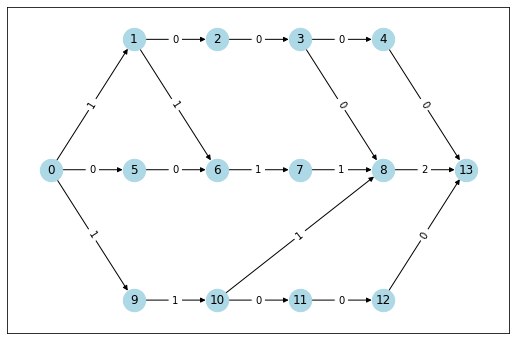

In [3]:
small_ex.optimize()
print(small_ex.objective)
small_ex.draw_graph()

In [4]:
# Could be useful in plotting taxi paths
# path = small_ex.taxi_paths()[0]
# path_nodes = list(zip(*path))[0]
# path_arcs = [(path_nodes[i],path_nodes[i+1]) for i in range(len(path_nodes)-1)]
# path_start, path_end = zip(*path_arcs)
# path_end

In [5]:
trips = pd.read_csv('data/2013-09-01_trip_data_manhattan.csv').drop(columns='id')
trips['value'] = 2.50 + 1.56*trips.trip_distance + 0.50*trips.trip_time
trips.value = trips.value.apply(lambda x: int(round(x,2)*100))
nodes = pd.read_csv('data/nyc_nodes_manhattan.csv').drop(columns='Unnamed: 0')
arcs = pd.read_csv('data/nyc_links_manhattan.csv').drop(columns='Unnamed: 0')

In [63]:
nyc_taxi = TaxiRouting(trips, nodes, arcs, 250, 370, 2000)

In [64]:
nyc_taxi.optimize()
print(nyc_taxi.objective/100)
print(sum(nyc_taxi.trips_df.value)/100)

42302.18
42302.18


In [68]:
test = nyc_taxi.taxi_locations()

In [69]:
location_vectors = {}
for t in range(nyc_taxi.T_max+1):
    location_vectors[t] = [test[i][t] for i in range(nyc_taxi.B_max)]

In [70]:
# load networkx model from edge dataset
# G = nx.from_pandas_edgelist(arcs, 'start', 'end', ['trip_time'])
# out = nx.single_source_dijkstra(G, 567, weight='trip_time')

# in_tree = pd.Series(np.zeros(nodes.shape[0]))
# in_tree[list(zip(*path))[0]] = 1
# in_tree = pd.Series(np.ones(arcs.shape[0])).index.map(in_tree)

# from graph_tools import plotShortestPathTree
# plotShortestPathTree(nodes, arcs, path)

In [107]:
taxis = [574,467]

In [108]:
# extract data
node_ids = dfn.name.values.tolist()
paths = nyc_taxi.taxi_paths()
start = []
end = []
for i in taxis:
    path = paths[i]
    path_nodes = list(zip(*path))[0]
    path_arcs = [(path_nodes[i],path_nodes[i+1]) for i in range(len(path_nodes)-1)]
    for arc in path_arcs:
        start.append(arc[0])
        end.append(arc[1])
x = dfn.x.values.tolist()
y = dfn.y.values.tolist()

In [109]:
# get plot boundaries
min_x, max_x = min(dfn.x)-2000, max(dfn.x)+2000
min_y, max_y = min(dfn.y)-2000, max(dfn.y)+2000

plot = figure(x_range=(min_x, max_x), y_range=(min_y, max_y),
              x_axis_type="mercator", y_axis_type="mercator",
              title='Path',
              plot_width=600, plot_height=470
             )

graph = GraphRenderer()

plot.add_tile(get_provider(Vendors.CARTODBPOSITRON_RETINA))

# define nodes
graph.node_renderer.data_source.add(node_ids, 'index')
graph.node_renderer.glyph = Circle(line_color='green', line_alpha=0,
                                   fill_color='green', size=3.5,
                                   fill_alpha=0
                                  )

 # define network edges
graph.edge_renderer.data_source.data = dict(start=list(start),
                                            end=list(end)
                                           )
graph.edge_renderer.glyph = MultiLine(line_color='steelblue',
                                      line_alpha=1, line_width=2
                                     )

# set node locations
graph_layout = dict(zip(node_ids, zip(x, y)))
graph.layout_provider = StaticLayoutProvider(graph_layout=graph_layout)

plot.renderers.append(graph)

show(plot)